# Получение данных

Для начала мы спарсим данные с википедии:

https://ru.wikipedia.org/wiki/Список_персонажей_серии_романов_о_Гарри_Поттере

Отсюда мы получим информацию о персонажах: их имя, оригинальное имя (на английском), пол, факультет и чистоту крови

"Должность" - это категория, к которой относится тот или иной персонаж, например студент, преподаватель или пожиратель смерти эти данные мы добавим вручную, так как собрать их с сайта википедии оказалось крайне проблематично

In [ ]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

url = "https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%BF%D0%B5%D1%80%D1%81%D0%BE%D0%BD%D0%B0%D0%B6%D0%B5%D0%B9_%D1%81%D0%B5%D1%80%D0%B8%D0%B8_%D1%80%D0%BE%D0%BC%D0%B0%D0%BD%D0%BE%D0%B2_%D0%BE_%D0%93%D0%B0%D1%80%D1%80%D0%B8_%D0%9F%D0%BE%D1%82%D1%82%D0%B5%D1%80%D0%B5"

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

names = []
english_names = []
genders = []
houses = []
blood = []
positions = []


# создаем функции чтобы получить английское имя из обычного:
# удаляем все после "(" и ","
def get_name_1(name):
    if '(англ.' in name:
        start = name.find('(англ.') + 6
        end = name.find(')', start)
        return name[start:end].split(",")[0].strip()
    return 'Неизвестно'


def get_name_2(name):
    name = name.split('(')[0].strip()
    if ',' in name:
        name = name.split(',')[0].strip()
    words = name.split()
    if len(words) > 2:
        name = f"{words[0]} {words[-1]}"
    return name


# также создаем функцию чтобы убрать из имени ненужные символы
def clean_character_name(name):
    if '(' in name:
        name = name.split('(')[0].strip()
    if '—' in name:
        name = name.split('—')[0].strip()
    if 'Основная статья:' in name:
        name = name.split('Основная статья:')[0].strip()
    return name


# находим таблицы с персонажами на википедии и обрабатываем их
tables = soup.find_all('table', {"class": "wikitable"})

for table in tables:
    rows = table.find_all('tr')
    headers = [header.text.strip() for header in rows[0].find_all('th')]

    try:
        name_index = headers.index('Имя')
        gender_index = headers.index('Пол')
        blood_status_index = headers.index('Чистота крови')
        faculty_index = headers.index('Факультет') if 'Факультет' in headers else None
    except ValueError as e:
        continue

    for row in rows[1:]:
        cols = row.find_all('td')
        if len(cols) <= name_index:
            continue
        name = clean_character_name(cols[name_index].text.strip())
        if name in ['', '...', '. . .']:
            continue
        english_name = get_name_1(cols[name_index].text.strip())
        english_name = get_name_2(english_name)
        gender = cols[gender_index].text.strip() if gender_index < len(cols) else 'Неизвестно'
        blood_status = cols[blood_status_index].text.strip() if blood_status_index < len(cols) else 'Неизвестно'
        faculty = cols[faculty_index].text.strip() if faculty_index and faculty_index < len(cols) else 'Неизвестно'

        names.append(name)
        english_names.append(english_name)
        genders.append(gender)
        houses.append(faculty)
        blood.append(blood_status)
        positions.append('Неизвестно')

# также приходится добавлять информацию для некоторых персонажей вручную,
# так как у них нет таблицы с данными как у остальных
for i, name in enumerate(names):
    if name == "Флёр Дела́кур":
        english_names[i] = "Fleur Delacour"
    elif name == "Ви́ктор Крам":
        english_names[i] = "Viktor Krum"
    elif name == "Бартемиус Крауч-младший":
        english_names[i] = "Bartemius Crouch, Jr."
    elif name == "Бартемиус «Ба́рти» Крауч-старший":
        english_names[i] = "Bartemius Crouch, Sr."
    elif name == "Джордж Фабиан Уизли":
        genders[i] = "мужской"
        blood[i] = "чистокровный"
    elif name == "Фредерик Гидеон Уизли":
        blood[i] = "чистокровный"
    elif name == "Ру́фус Скри́мджер":
        houses[i] = "Неизвестно"
    elif name == "Корне́лиус Фадж":
        houses[i] = "Когтевран"
    elif name == "Нимфадо́ра Лю́пин":
        houses[i] = "Пуффендуй"
    elif name == "А́льбус Да́мблдор":
        blood[i] = "полукровка"
    elif name == "Дже́ймс По́ттер":
        blood[i] = "чистокровный"

# теперь создаем списки персонажей по их должностям
students = ["Га́рри Дже́ймс По́ттер", "Ро́нальд Би́лиус Уи́зли", "Гермио́на Джин Гре́йнджер",
            "Джине́вра Мо́лли Уи́зли", "Фредерик Гидеон Уизли", "Джордж Фабиан Уизли",
            "Пе́рси Игна́циус Уи́зли", "Не́вилл Долгопу́пс", "Дра́ко Лю́циус Малфой",
            "Ви́нсент Крэбб", "Гре́гори Гойл", "Пэ́нси Па́ркинсон", "Полу́мна", "Се́дрик Ди́ггори"]

staff = ["А́льбус Да́мблдор", "Мине́рва Макго́нагалл", "Се́верус Снегг", "Ру́беус Ха́грид",
         "Квири́нус Кви́ррелл", "Златопуст Ло́конс", "Фи́лиус Фли́твик", "Сивилла Трелони",
         "Гора́ций Слизнорт", "А́ргус Филч"]

order = ["Дже́ймс По́ттер", "Ли́ли По́ттер", "Си́риус Блэк", "Ри́мус Лю́пин",
                        "Нимфадо́ра Лю́пин", "Арабе́лла До́рин Фигг", "Назе́мникус Фле́тчер",
                        "Ала́стор Грюм", "Уи́льям Би́лли Уи́зли", "Чарльз А́ртур Уи́зли",
                        "А́ртур Уи́зли", "Мо́лли Уи́зли"]

death_eaters = ["Волан-де-Мо́рт", "Беллатри́са Лестре́йндж", "Лю́циус Малфой",
                "Нарци́сса Малфой", "Бартемиус Крауч-младший", "Пи́тер Петтигрю"]

ministry = ["Ки́нгсли Бру́ствер", "Корне́лиус Фадж", "Бартемиус «Ба́рти» Крауч-старший",
                     "Ру́фус Скри́мджер", "Доло́рес А́мбридж"]

# присваиваем должности персонажам в соответствии со списками выше
for i, name in enumerate(names):
    if name in students:
        positions[i] = "Студент"
    elif name in staff:
        positions[i] = "Преподаватели и Персонал"
    elif name in order:
        positions[i] = "Орден Феникса"
    elif name in death_eaters:
        positions[i] = "Пожиратели Смерти"
    elif name in ministry:
        positions[i] = "Министерство магии"
    else:
        positions[i] = "Неизвестно"

# также нам приходится добавить вручную факультеты студентам
gryffindor = ["Га́рри Дже́ймс По́ттер", "Ро́нальд Би́лиус Уи́зли", "Гермио́на Джин Гре́йнджер",
                       "Джине́вра Мо́лли Уи́зли", "Фредерик Гидеон Уизли", "Джордж Фабиан Уизли",
                       "Пе́рси Игна́циус Уи́зли", "Не́вилл Долгопу́пс"]
slytherin = ["Дра́ко Лю́циус Малфой", "Ви́нсент Крэбб", "Гре́гори Гойл", "Пэ́нси Па́ркинсон"]
ravenclaw = ["Полу́мна"]
hufflepuff = ["Се́дрик Ди́ггори"]

for i, name in enumerate(names):
    if name in gryffindor:
        houses[i] = "Гриффиндор"
    elif name in slytherin:
        houses[i] = "Слизерин"
    elif name in ravenclaw:
        houses[i] = "Когтевран"
    elif name in hufflepuff:
        houses[i] = "Пуффендуй"

# теперь создаем датафрейм с полученными данными и включаем в него информацию о дополнительных персонажах,
# у которых не было своих табличек на википедии
df = pd.DataFrame({
    "Имя": names,
    "Имя на английском": english_names,
    "Пол": genders,
    "Факультет": houses,
    "Чистота крови": blood,
    "Должность": positions
})

additional_characters = [
    ('Лава́нда Бра́ун', 'Lavender Brown', 'женский', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Си́мус Фи́нниган', 'Seamus Finnigan', 'мужской', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Парвати Патил', 'Parvati Patil', 'женский', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Дин То́мас', 'Dean Thomas', 'мужской', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('О́ливер Вуд', 'Oliver Wood', 'мужской', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Кэ́ти Белл', 'Katie Bell', 'женский', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Ли Джо́рдан', 'Lee Jordan', 'мужской', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Анджели́на Джо́нсон', 'Angelina Johnson', 'женский', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Ко́лин Кри́ви', 'Colin Creevey', 'мужской', 'Гриффиндор', 'Неизвестно', 'Студент'),
    ('Ма́ркус Флинт', 'Marcus Flint', 'мужской', 'Слизерин', 'Неизвестно', 'Студент'),
    ('Чжо́у Чанг', 'Cho Chang', 'женский', 'Когтевран', 'Неизвестно', 'Студент'),
    ('Те́рри Бут', 'Terry Boot', 'мужской', 'Когтевран', 'Неизвестно', 'Студент'),
    ('Майкл Ко́рнер', 'Michael Corner', 'мужской', 'Когтевран', 'Неизвестно', 'Студент'),
    ('Мариэ́тта Э́джком', 'Marietta Edgecombe', 'женский', 'Когтевран', 'Неизвестно', 'Студент'),
    ('Ро́джер Дэ́вис', 'Roger Davies', 'мужской', 'Когтевран', 'Неизвестно', 'Студент'),
    ('Джа́стин Финч-Фле́тчли', 'Justin Finch-Fletchley', 'мужской', 'Пуффендуй', 'Неизвестно', 'Студент'),
    ('Ханна Аббот', 'Hannah Abbott', 'женский', 'Пуффендуй', 'Неизвестно', 'Студент'),
    ('Эрни Макми́ллан', 'Ernie Macmillan', 'мужской', 'Пуффендуй', 'Неизвестно', 'Студент'),
    ('Заха́рия Смит', 'Zacharias Smith', 'мужской', 'Пуффендуй', 'Неизвестно', 'Студент'),
    ('Помо́на Стебль', 'Pomona Sprout', 'женский', 'Пуффендуй', 'Неизвестно', 'Преподаватели и Персонал')
]

df_additional = pd.DataFrame(additional_characters,
                             columns=["Имя", "Имя на английском", "Пол", "Факультет", "Чистота крови", "Должность"])

new_df = pd.concat([df, df_additional], ignore_index=True)

# в процессе возникли дублирующиеся строки, так что мы удаляем повторяющиеся
new_df = new_df[new_df["Имя на английском"] != "Неизвестно"]
new_df = new_df[new_df["Имя"] != "Полумна Лавгуд"]
new_df = new_df[new_df["Имя"] != "Сириус Блэк"]
new_df = new_df[new_df["Имя"] != "Питер Петтигрю"]
new_df = new_df[new_df["Имя"] != "Лили Поттер"]

# этот датафрейм я создавала в процессе для того чтобы получить английские имена,
# чтобы создать с ними отдельную таблицу, куда я вручную вписывала типы личности
english = pd.DataFrame(new_df, columns=["Имя на английском"])

# сохраняем полный датафрейм в .csv файл
new_df.to_csv("harry_potter_characters.csv", index=False, encoding='utf-8-sig')
english.to_csv('english_names.csv', index=False, encoding='utf-8-sig')

И здесь нас уже ждут трудности:

Во-первых, не существует английской версии страницы, что упростило бы задачу

Во-вторых на странице не одна таблица со сведениями обо всех персонажах, а много отдельных, в некоторых присутствует ненужный дополнительный текст, у кого-то имена написаны не явно, а с датой рождения, например, вместо привычного "Рон Уизли" в таблице значится некто
"Ро́нальд Би́лиус Уи́зли (Рон Уи́зли)
(англ. Ronald Bilius «Ron» Weasley, род. 1 марта 1980 г.)". Некоторые персонажи идут отдельно, без отдельной таблицы, например, Лаванда Браун и Симус Финниган.

В-третьих, таблицы у персонажей содержат разные столбцы, потому что редакторы википедии не вписывают факультет в таблицу персонажу, если он указан в разделе студентов определенного факультета. То есть у нас есть песонаж Гарри Поттер, у которого нет факультета в таблице, а есть персонаж Минерва Макгонагалл, у которой факультет в таблице есть

Еще одна трудность это странные значения у определенных персонажей, например у Джеймса Поттера в графе "Чистота крови" написано "чистокровный?", а это не то же самое что "чистокровный" с точки зрения программы, у Корнелиуса Фаджа факультет непонятный даже для него самого: "Когтевран или Пуффендуй (возможно)", поэтому все эти неточности, ровно как и должности для всех персонажей и факультеты для студентов приходилось определять вручную


Теперь возьмем данные с сайта

https://www.personality-database.com/en-US/profile?pid=2&cid=12&sub_cat_id=624

(тоже может плохо работаеть без vpn)

мы будем опираться именно на книжных персонажей, а не на киновоплощения

с этого сайта данные также пришлось доставать вручную сначала в табличку в excel, а потом в .csv файл на гугл-диске, оттуда мы их возьмем и объединим с существующим датафреймом

In [ ]:
data=pd.read_csv('harry_potter_characters.csv', sep=",")
hp_personality_types = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hppers1.csv', sep=";")
hp_personality_types = hp_personality_types.head(69)
personality_type = hp_personality_types["Personality type"]

energy = pd.DataFrame(hp_personality_types["Energy"])
mind = pd.DataFrame(hp_personality_types["Mind"])
nature = pd.DataFrame(hp_personality_types["Nature"])
tactics = pd.DataFrame(hp_personality_types["Tactics"])

data['Тип личности'] = personality_type
data['Энергия: E/I'] = energy
data['Разум: N/S'] = mind
data['Натура: F/T'] = nature
data['Тактика: J/P'] = tactics
data.to_csv("hp_characters_personalities.csv", index=False, encoding='utf-8-sig')

После того как мы наконец-то спустя столько боли, крови, пота и страданий достали данные в таком виде, в котором они нам нужны, мы можем приступить к работе с ними

Для начала проанализируем, насколько часто встречается каждый из типов личности и каждая отдельная черта среди всех персонажей, построим пай чарт для наглядности. Цвета здесь и далее я брала с оригинального сайта https://www.16personalities.com/


# Построение диаграмм

16


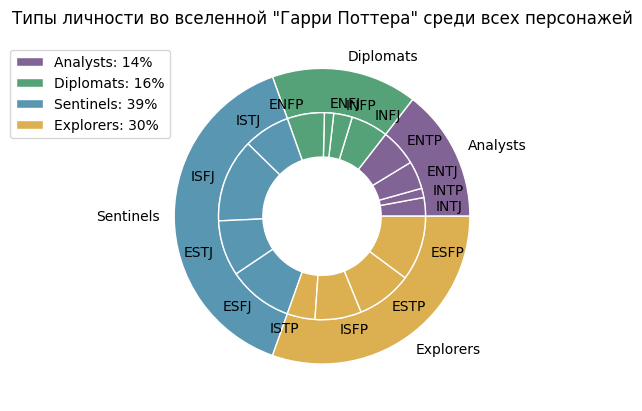

In [ ]:
# загружаем данные из сохраненного файла
data = pd.read_csv('hp_characters_personalities.csv', sep=",")

pers_types = data['Тип личности']
all_types_list = np.unique(pers_types)

#убедимся, что у нас присутствуют представители всех типов личности
print(len(all_types_list))

# создаем группы типов личности и цвета для каждой группы
personalities_groups = {
    'Analysts': ['INTJ', 'INTP', 'ENTJ', 'ENTP'],
    'Diplomats': ['INFJ', 'INFP', 'ENFJ', 'ENFP'],
    'Sentinels': ['ISTJ', 'ISFJ', 'ESTJ', 'ESFJ'],
    'Explorers': ['ISTP', 'ISFP', 'ESTP', 'ESFP']
}

group_colors = {
    'Analysts': '#826396',
    'Diplomats': '#56A278',
    'Sentinels': '#5996B1',
    'Explorers': '#DCB051'
}

# считаем количества типов личностей в каждой группе
group_counts = {group: 0 for group in personalities_groups}
type_counts = {ptype: 0 for ptype in np.unique(pers_types)}

for ptype in pers_types:
    for group, type_list in personalities_groups.items():
        if ptype in type_list:
            group_counts[group] += 1
            type_counts[ptype] += 1
            break

# создаем упорядоченный список типов личности
correct_order = [
    'INTJ', 'INTP', 'ENTJ', 'ENTP',
    'INFJ', 'INFP', 'ENFJ', 'ENFP',
    'ISTJ', 'ISFJ', 'ESTJ', 'ESFJ',
    'ISTP', 'ISFP', 'ESTP', 'ESFP'
]

# получаем данные для вложенной круговой диаграммы
group_sizes = [group_counts[group] for group in personalities_groups]
type_sizes = [type_counts[ptype] for ptype in correct_order]
group_labels = list(personalities_groups.keys())
type_labels = correct_order

list_group_colors = [group_colors[group] for group in group_labels]
list_type_colors = [group_colors[group] for ptype in correct_order for group, type_list in personalities_groups.items() if ptype in type_list]

# построим вложенную круговую диаграмму
fig, ax = plt.subplots()
wedges, texts = ax.pie(group_sizes, labels=group_labels, colors=list_group_colors, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
ax.pie(type_sizes, labels=type_labels, colors=list_type_colors, radius=0.7, wedgeprops=dict(width=0.3, edgecolor='w'))

ax.set(aspect="equal")

# создаем легенду с процентами
a = round((len(pers_types[pers_types=='INTJ']) + len(pers_types[pers_types=='INTP']) + len(pers_types[pers_types=='ENTJ']) + len(pers_types[pers_types=='ENTP'])) / len(pers_types) * 100)
d = round((len(pers_types[pers_types=='INFJ']) + len(pers_types[pers_types=='INFP']) + len(pers_types[pers_types=='ENFJ']) + len(pers_types[pers_types=='ENFP'])) / len(pers_types) * 100)
s = round((len(pers_types[pers_types=='ISTJ']) + len(pers_types[pers_types=='ISFJ']) + len(pers_types[pers_types=='ESTJ']) + len(pers_types[pers_types=='ESFJ'])) / len(pers_types) * 100)
e = round((len(pers_types[pers_types=='ISTP']) + len(pers_types[pers_types=='ISFP']) + len(pers_types[pers_types=='ESTP']) + len(pers_types[pers_types=='ESFP'])) / len(pers_types) * 100)

percent_groups = [
    f'Analysts: {a}%',
    f'Diplomats: {d}%',
    f'Sentinels: {s}%',
    f'Explorers: {e}%'
]

plt.title('Типы личности во вселенной "Гарри Поттера" среди всех персонажей')
plt.legend(labels=percent_groups, bbox_to_anchor = (-0.16, 0.45, 0.25, 0.5), borderaxespad=0.)

plt.show()

Здесь analysts, diplomats, sentinels и explorers - это отдельные группы типы личностей с двумя одинковыми чертами: NT, NF, SJ, SP
найти их также можно по ссылке https://www.16personalities.com/personality-types



Теперь можем посмотреть на распределение по отдельным чертам

[[55.07, 44.93], [30.43, 69.57], [56.52, 43.48], [53.62, 46.38]]


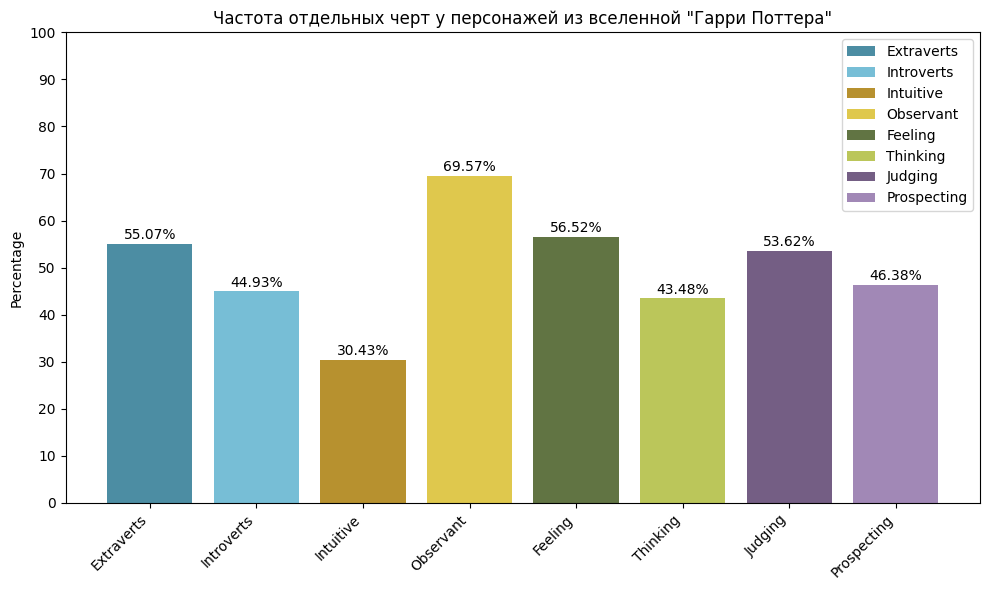

In [ ]:
traits=['Энергия: E/I', 'Разум: N/S', 'Натура: F/T', 'Тактика: J/P']
#когда программа перебирает traits, она считывает их в алфавитном порядке,
#но на всякий случай мы перестрахуемся и будем вручную контролировать,
#чтобы случайно 'E' не считались в интровертов

total=len(data['Энергия: E/I'])
all_traits=[]
for t in traits:
  if t=='Энергия: E/I':
    trait_one='E'
    trait_two='I'
    one='Extraverts'
    two='Introverts'
    colors=['#4C8DA3', '#77BED6']
  elif t=='Разум: N/S':
    trait_one='N'
    trait_two='S'
    one='Intuitive'
    two='Observant'
    colors=['#B7912F', '#DFC84D']
  elif t=='Натура: F/T':
    trait_one='F'
    trait_two='T'
    one='Feeling'
    two='Thinking'
    colors=['#617443', '#BBC65A']
  else:
    trait_one='J'
    trait_two='P'
    one='Judging'
    two='Prospecting'
    colors=['#745E84', '#A188B6']

  trait=data[t]
  all_types_list=np.unique(trait)
  frequency=0
  type_frequencies=[]
  first=0
  second=0
  for i in all_types_list:
      if i == trait_one:
        first=round((len(trait[trait==i])/total)*100, 2)
      else:
        second=round((len(trait[trait==i])/total)*100, 2)
  type_frequencies=[first, second]
  all_traits.append(type_frequencies)
print(all_traits)

labels = ['Extraverts', 'Introverts', 'Intuitive', 'Observant', 'Feeling', 'Thinking', 'Judging', 'Prospecting']
colors = ['#4C8DA3', '#77BED6', '#B7912F', '#DFC84D', '#617443', '#BBC65A', '#745E84', '#A188B6']

# для удобства преобразовываем данные и строим столбчатую диаграмму
data_flat = [item for sublist in all_traits for item in sublist]
positions = np.arange(len(data_flat))

fig, ax = plt.subplots(figsize=(10, 6))

for i, (pos, height, color) in enumerate(zip(positions, data_flat, colors)):
    ax.bar(pos, height, color=color, label=labels[i])
    ax.text(pos, height + 1, f'{height}%', ha='center', fontsize=10)

ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylim(0, 100)
ax.set_ylabel('Percentage')
ax.set_title('Частота отдельных черт у персонажей из вселенной "Гарри Поттера"')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Гипотезы

Теперь проделаем то же самое для отдельных групп персонажей. Мы рассмотрим разные факультеты и должности а так же представителей разных полов

Мы сравним процентное(!) содержание людей с теми или иными чертами личности среди определенных категорий персонажей с процентным среди всех персонажей (так как в природе случилось так, что их не поровну) и проверим некоторые гипотезы

## *Дисклеймер*

Поскольку это все-таки персонажи книги, и автор при написании могла сама делать их такими, какими ей угодно, она могла подстраивать персонажей под ситуацию и под сюжет. В реальности человек, сколько-нибудь сформировавшийся, имеет свой тип личности, и он не меняется так, чтобы лучше всего подстроиться под ту жизнь, которая у него есть, поэтому те гипотезы, которые в реальной жизни были бы абсурдными, в рамках персонажей имеют место быть


##**Гипотезы следующие:**

1.   Среди сотрудников **Министерства Магии** должно быть больше персонажей с чертой **'J'**, так как, люди с такой чертой склонны создавать свой порядок, свои правила вместо того чтобы адаптироваться к ситуации или чьим-то еще правилам

2.    Среди **Преподавателей и Персонала** должно быть больше представителей **J-типов**, так как опять же обладатели этой черты организованы и создают свой порядок, что свойственно преподавателям

3.  Среди **Пожирателей Смерти** должно быть больше **T-типов**, так как эмпатия и чувства вряд ли ведомы тем, кто поддерживал идеи Темного Лорда, пытал и убивал людей

4. Среди **Когтевранцев** должно быть больше представителей **N-типов**, так как, по канонам книги, на этот факультет попадали обычно люди, открытые к новому, увлеченные своими идеями

5. Среди **Студентов** должно быть больше **P** типов, поскольку у студентов наверняка должны быть хорошо развиты навыки адаптации к среде, в которую они попадают

6. Проверим также стереотип, что среди женщин больше чувствующих, чем думающих, а среди мужчин - наоборот, то есть среди **женщин** должно быть больше **'F'**


In [ ]:
# создадим функцию, чтобы облегчить проверку наших гипотез
def specified_statistics(data, criterion, value):
  data = data[data[criterion] == value]

  total=len(data['Энергия: E/I'])
  all_traits=[]
  for t in traits:
    if t=='Энергия: E/I':
      trait_one='E'
      trait_two='I'
      one='Extraverts'
      two='Introverts'
      colors=['#4C8DA3', '#77BED6']
    elif t=='Разум: N/S':
      trait_one='N'
      trait_two='S'
      one='Intuitive'
      two='Observant'
      colors=['#B7912F', '#DFC84D']
    elif t=='Натура: F/T':
      trait_one='F'
      trait_two='T'
      one='Feeling'
      two='Thinking'
      colors=['#617443', '#BBC65A']
    else:
      trait_one='J'
      trait_two='P'
      one='Judging'
      two='Prospecting'
      colors=['#745E84', '#A188B6']


    trait=data[t]
    types=np.unique(trait)
    frequency=0
    type_frequencies=[]
    first=0
    second=0
    for i in types:
        if i == trait_one:
          first=round((len(trait[trait==i])/total)*100, 2)
        else:
          second=round((len(trait[trait==i])/total)*100, 2)
    type_frequencies=[first, second]
    all_traits.append(type_frequencies)

  labels = ['Extraverts', 'Introverts', 'Intuitive', 'Observant', 'Feeling', 'Thinking', 'Judging', 'Prospecting']
  colors = ['#4C8DA3', '#77BED6', '#B7912F', '#DFC84D', '#617443', '#BBC65A', '#745E84', '#A188B6']

  data_flat = [item for sublist in all_traits for item in sublist]
  positions = np.arange(len(data_flat))

  fig, ax = plt.subplots(figsize=(10, 6))

  for i, (pos, height, color) in enumerate(zip(positions, data_flat, colors)):
      ax.bar(pos, height, color=color, label=labels[i])
      ax.text(pos, height + 1, f'{height}%', ha='center', fontsize=10)

  ax.set_xticks(positions)
  ax.set_xticklabels(labels, rotation=45, ha='right')
  ax.set_yticks(np.arange(0, 101, 10))
  ax.set_ylim(0, 100)
  ax.set_ylabel('Percentage')
  ax.set_title(f'Частота отдельных черт у персонажей из вселенной "Гарри Поттера", у которых {criterion} - {value}')
  ax.legend(loc='upper right')

  plt.tight_layout()
  plt.show()

# Гипотеза 1

Министерство Магии -- больше 'J':

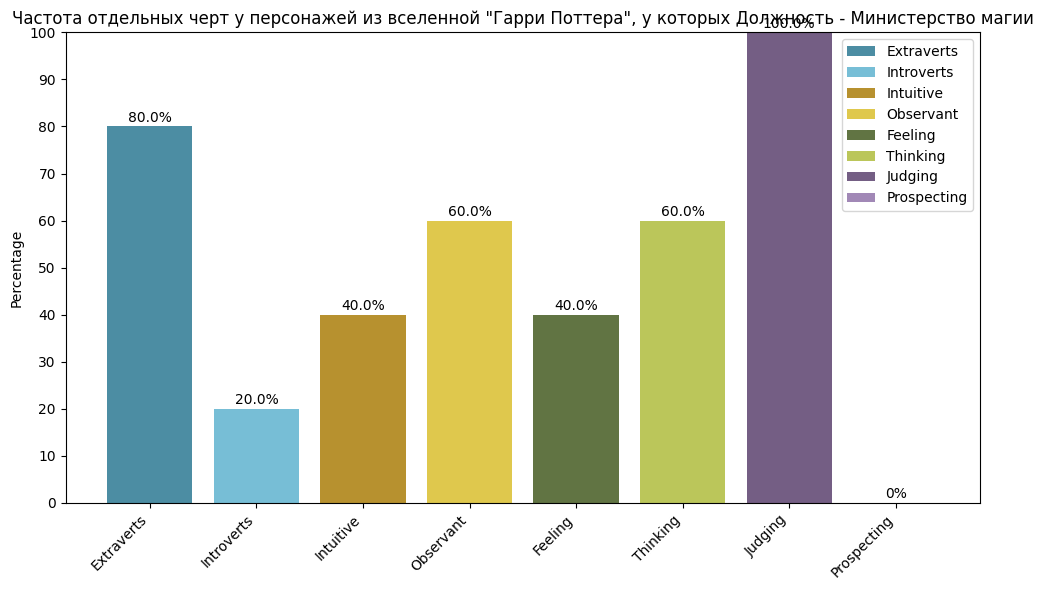

In [ ]:
specified_statistics(data, 'Должность', 'Министерство магии')

Гипотеза 1 оказалась верной: все представители Министерства магии - Judging

# Гипотеза 2

Преподаватели и Персонал -- больше J-типов

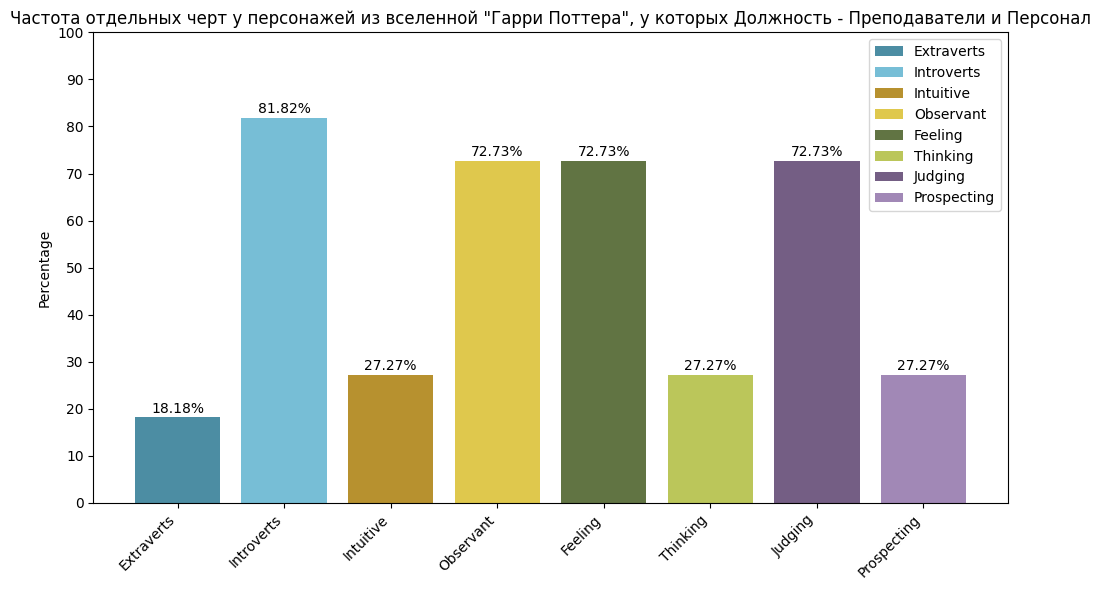

In [ ]:
specified_statistics(data, 'Должность', 'Преподаватели и Персонал')

Гипотеза оказалась верной, т. к. видно, что среди преподавателей преобладают персонажи с чертой J

# Гипотеза 3

Пожиратели Смерти -- больше T-типов

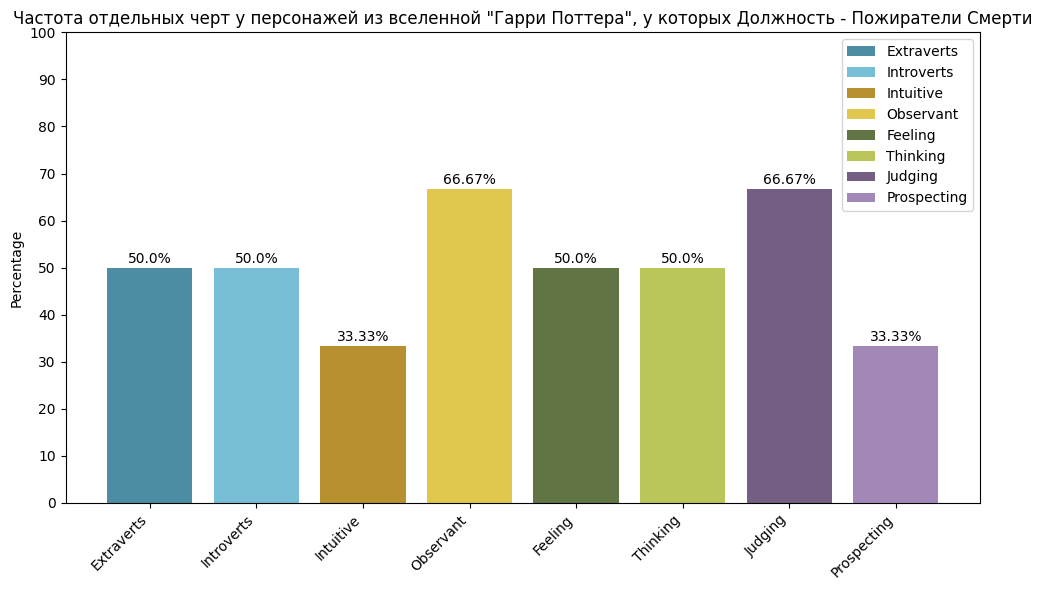

In [ ]:
specified_statistics(data, 'Должность', 'Пожиратели Смерти')

Гипотеза 3 верна!

В среднем было 43.48% Thinking, а среди Пожирателей Смерти - 50.00%

# Гипотеза 4

Когтевранцы -- больше N-типов

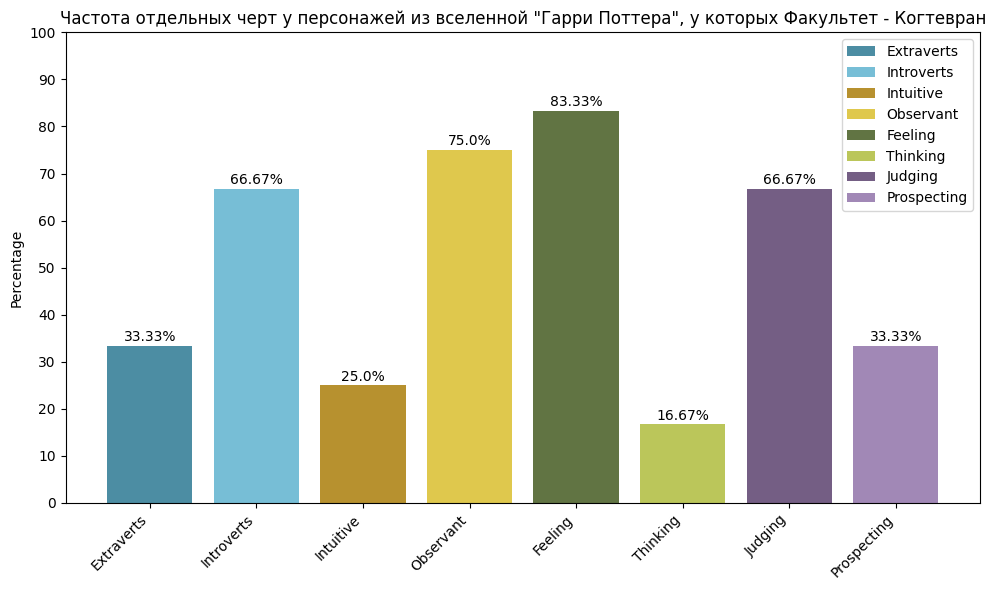

In [ ]:
specified_statistics(data, 'Факультет', 'Когтевран')

Гипотеза 4 опять оказалась неверна

# Гипотеза 5

Студенты -- больше P типов

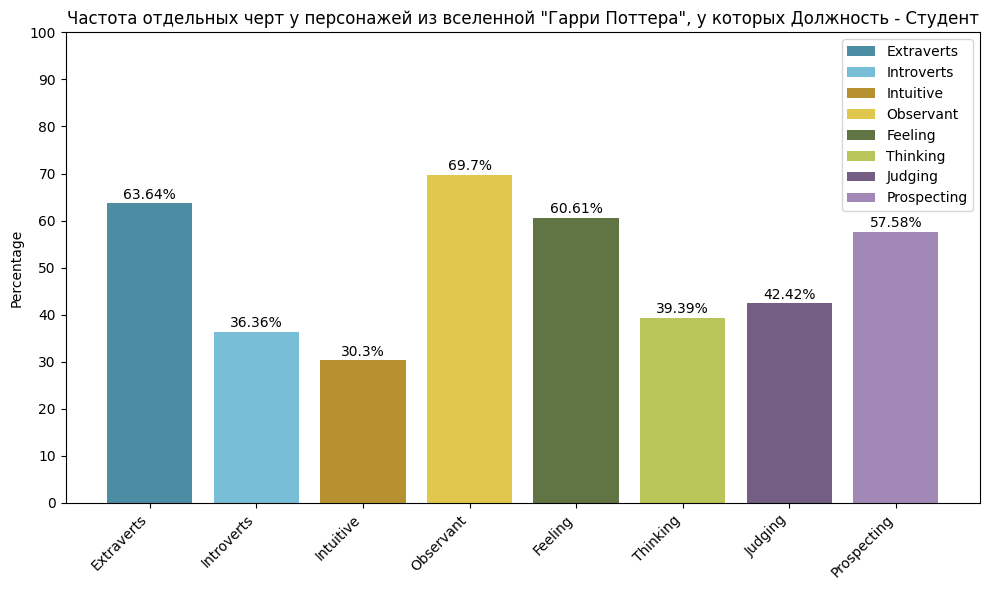

In [ ]:
specified_statistics(data, 'Должность', 'Студент')

Гипотеза 5 оправдала надежды!
По всем персонажам Prospecting было 46.38%, а среди студентов -- 57,58%.

# Гипотеза 6

Женщины -- больше 'F'

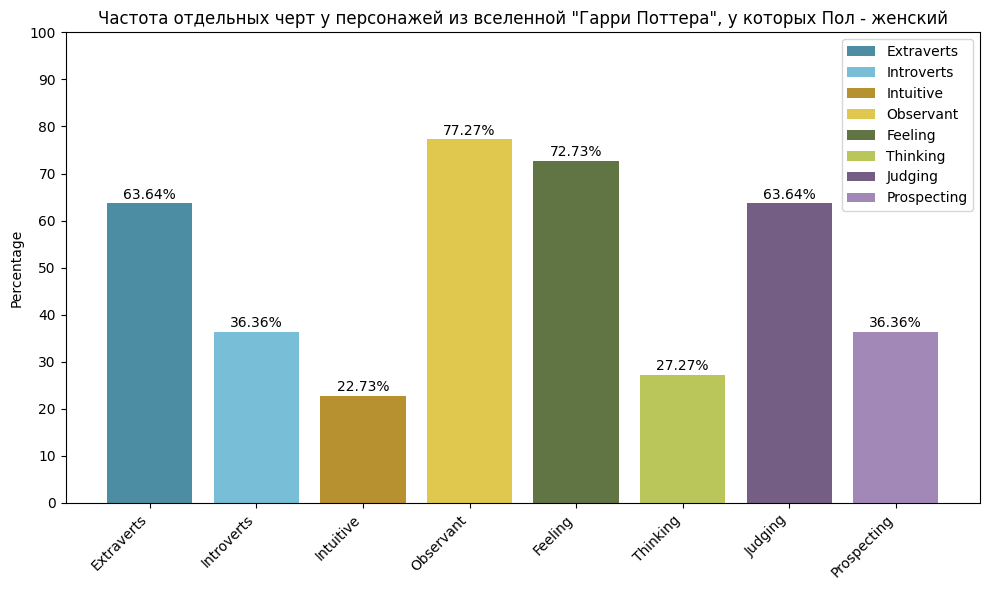

In [ ]:
specified_statistics(data, 'Пол', 'женский')

Гипотеза номер 6 оказалась еще какой правдой

Однако намного интереснее выглядит распределение
у мужчин, давайте взглянем

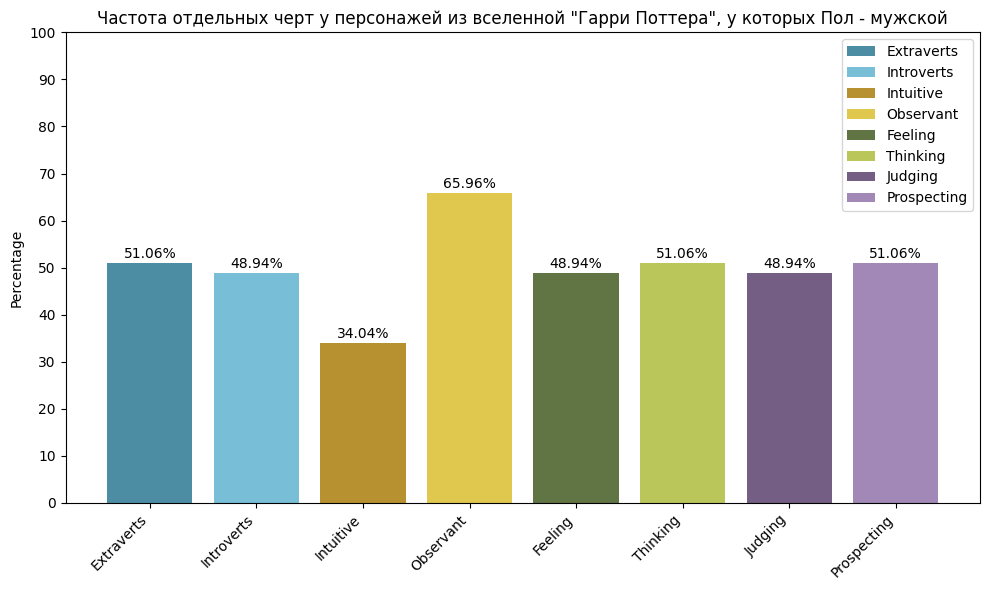

In [ ]:
specified_statistics(data, 'Пол', 'мужской')

Видимо, у мужчин все намного разнообразнее, особенно по сравнению с женщинами

# Графы

Теперь построим несколько графов с помощью библиотеки networkx и взглянем на них

In [ ]:
!pip install networkx

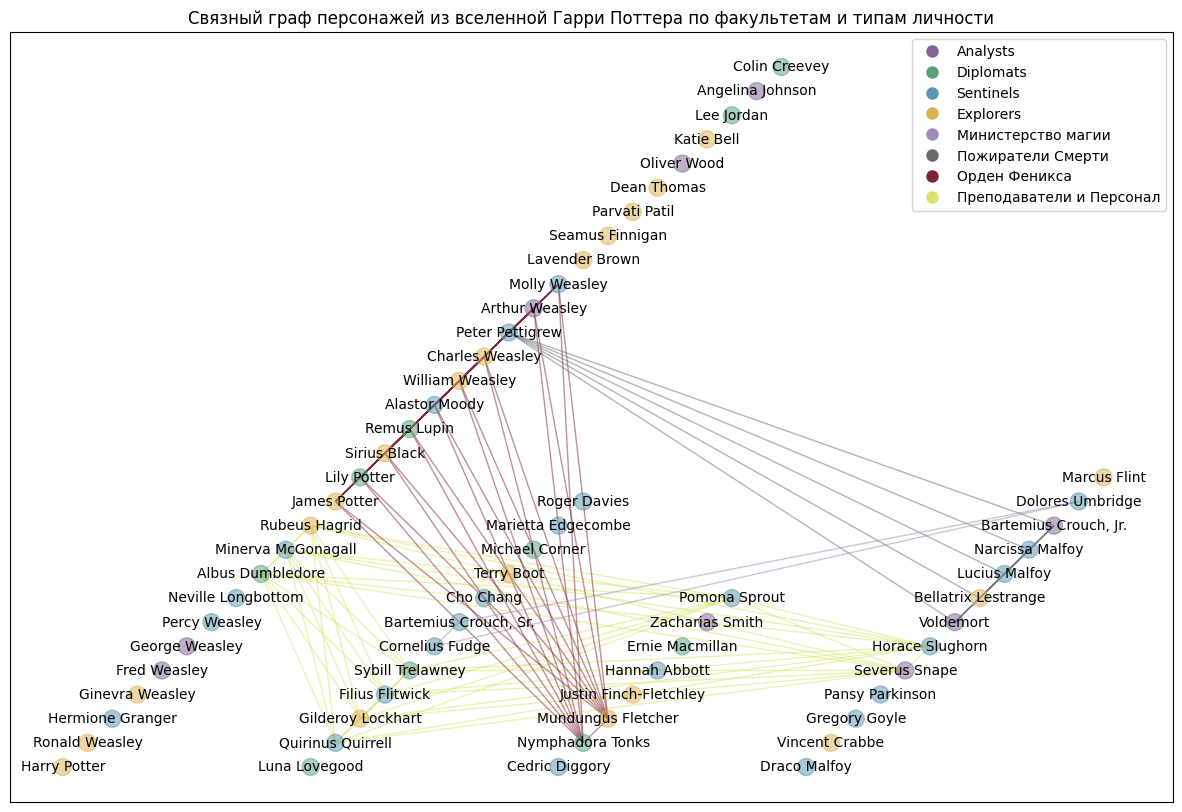

In [ ]:
# для удобства убираем персонажей, у которых факультета или нет или он неизвестен
data = pd.read_csv('/content/hp_characters_personalities.csv')
data = data[data['Факультет'] != 'нет']
data = data[data['Факультет'] != 'Неизвестно']
data = data[data['Факультет'] != 'Неизвестен']

# определяем цвета для должностей, не включая при этом студентов,
# потому что иначе график будет перегружен связями
function_colors = {
    'Министерство магии': '#A189B7',
    'Пожиратели Смерти': '#686A6C',
    'Орден Феникса': '#7F2332',
    'Преподаватели и Персонал': '#DBE36B'
}
# создаем граф
G = nx.Graph()
for _, row in data.iterrows():
    G.add_node(row['Имя на английском'],
               house=row['Факультет'],
               role=row['Должность'],
               personality=row['Тип личности'])

functions = ['Министерство магии', 'Преподаватели и Персонал', 'Орден Феникса', 'Пожиратели Смерти']
for f in functions:
    characters = data[data['Должность'] == f]['Имя на английском'].tolist()
    for i in range(len(characters)):
        for j in range(i + 1, len(characters)):
            G.add_edge(characters[i], characters[j])
# создаем вершины и ребра
node_colors = []
for node in G.nodes(data=True):
    personality = node[1]['personality']
    for group, all_types_list in personalities_groups.items():
        if personality in all_types_list:
            node_colors.append(group_colors[group])
            break

edge_colors = []
for edge in G.edges():
    function = data[data['Имя на английском'] == edge[0]]['Должность'].values[0]
    edge_colors.append(function_colors[function])

houses = data['Факультет'].unique()
pos = {}
group_positions = {
    'Гриффиндор': (0, 0),
    'Когтевран': (2, 0),
    'Пуффендуй': (4, 0),
    'Слизерин': (6, 0)
}

for house in houses:
    characters = data[data['Факультет'] == house]['Имя на английском'].tolist()
    for idx, character in enumerate(characters):
        pos[character] = (group_positions[house][0] + 0.2 * idx, group_positions[house][1] + 0.5 * idx)

# строим граф
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=150, alpha=0.5)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.5)
nx.draw_networkx_labels(G, pos, {node: node for node in G.nodes()}, font_size=10)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Analysts', markerfacecolor='#826396', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Diplomats', markerfacecolor='#56A278', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Sentinels', markerfacecolor='#5996B1', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Explorers', markerfacecolor='#DCB051', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Министерство магии', markerfacecolor='#A189B7', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Пожиратели Смерти', markerfacecolor='#686A6C', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Орден Феникса', markerfacecolor='#7F2332', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Преподаватели и Персонал', markerfacecolor='#DBE36B', markersize=10)
                  ]

plt.legend(handles=legend_elements, loc='best')

plt.title('Связный граф персонажей из вселенной Гарри Поттера по факультетам и типам личности')
plt.show()

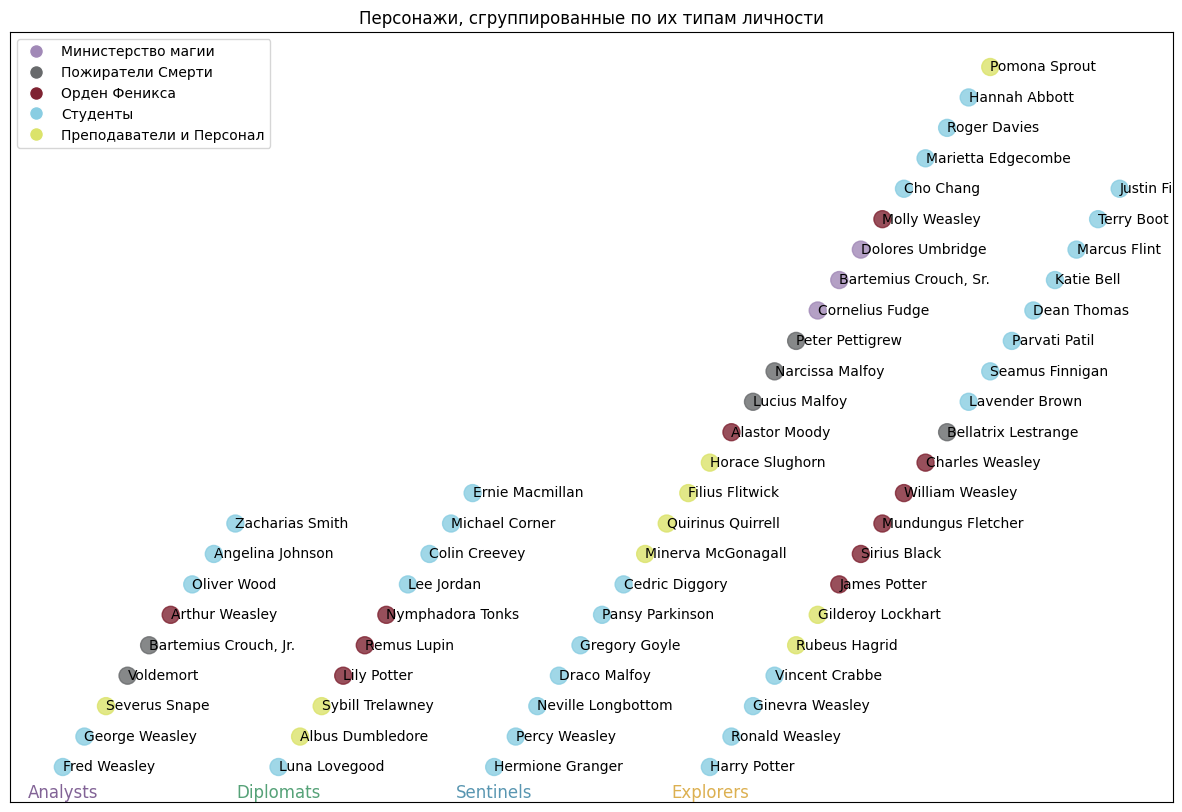

In [ ]:
# убираем из данных персонажей, у которых нет факультетов
data = data[data['Факультет'] != 'нет']
data = data[data['Факультет'] != 'Неизвестно']
data = data[data['Факультет'] != 'Неизвестен']

# создаем граф
G = nx.Graph()

for _, row in data.iterrows():
    G.add_node(row['Имя на английском'],
               house=row['Факультет'],
               role=row['Должность'],
               personality=row['Тип личности'])

# определяем цвета в зависимости от должности
function_colors = {
    'Министерство магии': '#A189B7',
    'Пожиратели Смерти': '#686A6C',
    'Орден Феникса': '#7F2332',
    'Студент': '#89CDE2',
    'Преподаватели и Персонал': '#DBE36B'
}

node_colors = []
for node in G.nodes(data=True):
    func = node[1]['role']
    node_colors.append(function_colors[func])

pos = {}
group_positions = {
    'Analysts': (0, 0),
    'Diplomats': (2, 0),
    'Sentinels': (4, 0),
    'Explorers': (6, 0)
}

for group, all_types_list in personalities_groups.items():
    characters = data[data['Тип личности'].isin(all_types_list)]['Имя на английском'].tolist()
    for idx, character in enumerate(characters):
        pos[character] = (group_positions[group][0] + 0.2 * idx, group_positions[group][1] + 0.5 * idx)

# строим граф
plt.figure(figsize=(15, 10))

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=150, alpha=0.8)
nx.draw_networkx_labels(G, pos, {node: node for node in G.nodes()}, font_size=10, verticalalignment='center', horizontalalignment='left')

for group, (x, y) in group_positions.items():
    plt.text(x, y - 0.5, group, fontsize=12, ha='center', color=group_colors[group])

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Министерство магии', markerfacecolor='#A189B7', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Пожиратели Смерти', markerfacecolor='#686A6C', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Орден Феникса', markerfacecolor='#7F2332', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Студенты', markerfacecolor='#89CDE2', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Преподаватели и Персонал', markerfacecolor='#DBE36B', markersize=10)
                  ]

plt.legend(handles=legend_elements, loc='best')

plt.title('Персонажи, сгруппированные по их типам личности')
plt.show()